In [1]:
#import ipynb.fs.full.prepare_training_data as train

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.utils.data as data_utils

In [80]:
input_ = np.load('/home/vishesh/TUM/Thesis/coref-json/input_.npy')

In [81]:
output_ = np.load('/home/vishesh/TUM/Thesis/coref-json/output_.npy')

In [117]:
output_[10]

array([0])

In [82]:
input_[0].shape

(1239, 1)

In [110]:
input_dim = 1239
hidden_dim1 = 300
hidden_dim2 = 200
hidden_dim3 = 500
output_dim = 2
batch_size = 8
num_epochs = 5

In [84]:
# Numpy ndarray list to torch tensor list
input_tensor_list = []
for tensor in input_:
    input_tensor_list.append((torch.from_numpy(tensor.reshape(1239))).float())

In [85]:
output_tensor_list = []
for tensor in output_:
    output_tensor_list.append((torch.from_numpy(tensor)))

In [86]:
print (len(input_tensor_list))
print (len(output_tensor_list))

6090
6090


In [92]:
input_tensor = torch.Tensor(5000, 1239)
torch.cat(input_tensor_list[:5000], out = input_tensor)



 -0.2243
  0.2743
  0.0547
   ⋮    
  1.0000
  0.0000
  1.0000
[torch.FloatTensor of size 6195000]

In [93]:
label_tensor = torch.LongTensor(5000, 1)
torch.cat(output_tensor_list[:5000], out = label_tensor)
#label_tensor = label_tensor.view(129054, 1)


 0
 0
 1
⋮ 
 0
 0
 1
[torch.LongTensor of size 5000]

In [94]:
test_input_tensor = torch.Tensor(1090, 1239)
torch.cat(input_tensor_list[5000:], out = test_input_tensor)


 0.3020
-0.1389
-0.1218
   ⋮   
 0.0000
 0.0000
 0.0000
[torch.FloatTensor of size 1350510]

In [95]:
test_label_tensor = torch.LongTensor(1090, 1)
torch.cat(output_tensor_list[5000:], out = test_label_tensor)


 0
 0
 0
⋮ 
 1
 1
 0
[torch.LongTensor of size 1090]

In [96]:
input_tensor = input_tensor.view(5000, 1239)
test_input_tensor = test_input_tensor.view(1090, 1239)

In [97]:
train = data_utils.TensorDataset(input_tensor, label_tensor)
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

In [98]:
test = data_utils.TensorDataset(test_input_tensor, test_label_tensor)
test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=False)

In [99]:
len(train_loader)

625

In [104]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(FFNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()

        #self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        #self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        #x = x.view(-1, 1337)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        #out = self.fc3(out)
        #out = self.relu3(out)
        out = self.fc4(out)
        
        return out
        

In [111]:
model = FFNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

In [112]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Loss Function
criterion = nn.CrossEntropyLoss()

In [113]:
iter = 0
loss_list = []
f1_list = []
iter_list = []
for epoch in range(50):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)  
        optimizer.zero_grad()
        outputs = model(inputs)   
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()

        iter += 1
        if iter % 500 == 0:
            tp = 0
            fp = 0
            fn = 0
            #correct = 0
            #total = 0
            #accuracy = 0
            for inputs, labels in test_loader:
                inputs = Variable(inputs)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                #print (outputs)
                #print (_)
                for l, p in zip(labels, predicted):
                    if l == 1 and p == 1:
                        tp += 1
                    if l == 0 and p == 1:
                        fp += 1
                    if l == 1 and p == 0:
                        fn += 1        
                #correct += (labels == predicted).sum()
            print ('true positive: ' + str(tp))
            print ('false positive: ' + str(fp))
            print ('false negative: ' + str(fn))
            if tp == 0 and fp == 0:
                precision = 0
            else:
                precision = tp / (tp + fp)
            if tp == 0 and fn == 0:
                recall = 0
            else:
                recall = tp / (tp + fn)
            if precision == 0 and recall == 0:
                f1 = 0
            else:
                f1 = (2 * precision * recall) / (precision + recall)
            loss_list.append(loss.data[0])
            f1_list.append(f1)
            iter_list.append(iter)

            
            #accuracy = correct/total * 100
            print ('Epoch: {}, Iteration: {}, Loss: {}, Precision: {}, Recall: {}, F1: {}'.format(epoch, iter, loss.data[0], precision, recall, f1))

true positive: 0
false positive: 0
false negative: 161
Epoch: 0, Iteration: 500, Loss: 0.338083952665329, Precision: 0, Recall: 0.0, F1: 0
true positive: 0
false positive: 0
false negative: 161
Epoch: 1, Iteration: 1000, Loss: 0.14140631258487701, Precision: 0, Recall: 0.0, F1: 0
true positive: 41
false positive: 0
false negative: 120
Epoch: 2, Iteration: 1500, Loss: 0.06965839862823486, Precision: 1.0, Recall: 0.2546583850931677, F1: 0.4059405940594059
true positive: 76
false positive: 32
false negative: 85
Epoch: 3, Iteration: 2000, Loss: 0.7698437571525574, Precision: 0.7037037037037037, Recall: 0.4720496894409938, F1: 0.5650557620817844
true positive: 95
false positive: 28
false negative: 66
Epoch: 3, Iteration: 2500, Loss: 0.0356283113360405, Precision: 0.7723577235772358, Recall: 0.5900621118012422, F1: 0.6690140845070423
true positive: 92
false positive: 10
false negative: 69
Epoch: 4, Iteration: 3000, Loss: 0.3427479863166809, Precision: 0.9019607843137255, Recall: 0.5714285714

true positive: 141
false positive: 31
false negative: 20
Epoch: 35, Iteration: 22000, Loss: 4.068656096478662e-07, Precision: 0.8197674418604651, Recall: 0.8757763975155279, F1: 0.8468468468468469
true positive: 142
false positive: 35
false negative: 19
Epoch: 35, Iteration: 22500, Loss: 3.0178816246007045e-07, Precision: 0.8022598870056498, Recall: 0.8819875776397516, F1: 0.8402366863905325
true positive: 124
false positive: 26
false negative: 37
Epoch: 36, Iteration: 23000, Loss: 0.0004473348380997777, Precision: 0.8266666666666667, Recall: 0.7701863354037267, F1: 0.797427652733119
true positive: 140
false positive: 36
false negative: 21
Epoch: 37, Iteration: 23500, Loss: 0.00020146259339526296, Precision: 0.7954545454545454, Recall: 0.8695652173913043, F1: 0.830860534124629
true positive: 142
false positive: 29
false negative: 19
Epoch: 38, Iteration: 24000, Loss: 1.9983590391348116e-05, Precision: 0.8304093567251462, Recall: 0.8819875776397516, F1: 0.8554216867469879
true positive:

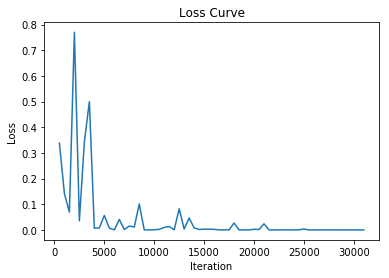

In [114]:
plt.plot(iter_list, loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

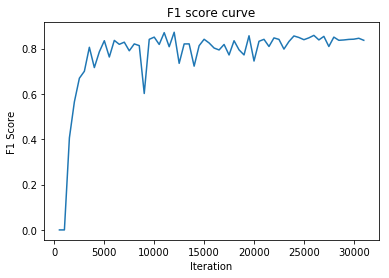

In [115]:
plt.plot(iter_list, f1_list)
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('F1 score curve')
plt.show()

In [342]:
pre

Variable containing:
 2.4668 -2.4418
[torch.FloatTensor of size 1x2]

In [343]:
actual = output_tensor_list[99999]

In [344]:
actual


 0
[torch.LongTensor of size 1]